In [1]:
'''
Analyze volume for all cattle commodities split by before and after an arbitrary contract month and year
For each contract we plot the following:
- Average Daily Nominal Trading Volume By Minute
- Average Daily Normalized Trading Volume By Minute
'''
import pandas as pd
import os
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import trange, tqdm
from datetime import datetime

In [2]:
CONTRACTS_PREFIX_MATCHER = 'LEM' # Only contracts with filenames matching this prefix will be analyzed
SPLIT_DATE_CUTOFF = '2015-06-07' # The date to use for splitting the contracts into a before and after

In [3]:
# Set plotly as the plotting engine for pandas for convenience
pd.options.plotting.backend = "plotly"

In [4]:
# Get a list of all the csv files to process
csv_files = []
for file in os.listdir("../data/raw/firstratedata_futures"):
    if file.startswith(CONTRACTS_PREFIX_MATCHER):
        csv_files.append(file)
csv_files.sort()
csv_files

['LEM08.csv',
 'LEM09.csv',
 'LEM10.csv',
 'LEM11.csv',
 'LEM12.csv',
 'LEM13.csv',
 'LEM14.csv',
 'LEM15.csv',
 'LEM16.csv',
 'LEM17.csv',
 'LEM18.csv',
 'LEM19.csv',
 'LEM20.csv']

In [5]:
def convert_csv_to_df(filename):
    df_volume = pd.read_csv(
        f"../data/raw/firstratedata_futures/{filename}",
        parse_dates=['DateTime'], usecols=['DateTime', 'Volume'], index_col=['DateTime']
    )
    return df_volume

In [6]:
def get_unique_trading_days(df):
    '''Calculate the number of unique trading days in the dataset'''
    unique_trading_days = df.index.map(lambda t: t.date()).unique()
    return unique_trading_days

In [7]:
def initialize_df_grouped_by_minute():
    '''Initialize an empty dataframe with no data and an index with a row for each minute of the day'''
    date_range = pd.date_range(start='1/1/2021', end='1/02/2021', freq='T')[:-1]
    new_df = pd.DataFrame(data={'DateTime':date_range}).set_index('DateTime')
    new_df = new_df.groupby(lambda x: x.time()).sum()
    return new_df

In [8]:
def combine_data_frames(df1,df2):
    combined_df = pd.concat([df1, df2])
    return combined_df

In [9]:
def get_master_ungrouped_data_frame(files_to_process):
    '''Build up a single dataframe containing volume and DateTime for all contracts'''
    initial_df = pd.DataFrame(columns = ["DateTime", "Volume"]).set_index('DateTime')
    for i in trange(len(files_to_process), desc=f"Overall Analysis"):
        file = files_to_process[i]
        contract_symbol = file[:len(file) - 4]
        a_contract_df = convert_csv_to_df(file)
        initial_df = combine_data_frames(initial_df, a_contract_df)
        # display(a_contract_df)
    return initial_df

In [10]:
def resample_volume_by_minute(df):
    '''Resample the data-set by minute filling in the gaps and summing the trading volume within each minute'''
    df_temp = df.resample('1T').sum()[["Volume"]]
    df_volume_by_minute = df_temp.groupby(lambda x: x.time()).sum()
    return df_volume_by_minute

In [11]:
def split_dataframe_by_date(df, split_date):
    '''Split a dataframe into two dataframes. Onecontains all rows before the split_date and the other contains all rows after it'''
    before_date_df = master_ungrouped_df[master_ungrouped_df.index.date < datetime.strptime(split_date, '%Y-%m-%d').date()].copy()
    after_date_df = master_ungrouped_df[master_ungrouped_df.index.date >= datetime.strptime(split_date, '%Y-%m-%d').date()].copy()
    return (before_date_df, after_date_df)

In [12]:
master_avg_daily_nominal_df = initialize_df_grouped_by_minute()
master_avg_daily_normalized_df = initialize_df_grouped_by_minute()
master_ungrouped_df = get_master_ungrouped_data_frame(csv_files)

Overall Analysis:   0%|          | 0/13 [00:00<?, ?it/s]

In [13]:
master_ungrouped_df = master_ungrouped_df.sort_values(by=['DateTime'])
before_date_df, after_date_df = split_dataframe_by_date(master_ungrouped_df, SPLIT_DATE_CUTOFF)
before_date_unique_trading_days = len(get_unique_trading_days(before_date_df))
after_date_unique_trading_days = len(get_unique_trading_days(after_date_df))
before_date_by_minute_df = resample_volume_by_minute(before_date_df)
after_date_by_minute_df = resample_volume_by_minute(after_date_df)

In [14]:
before_date_by_minute_df = before_date_by_minute_df.rename(columns={'Volume':f"Total Volume Before {SPLIT_DATE_CUTOFF}"})
before_date_by_minute_df[f"Average Volume Before {SPLIT_DATE_CUTOFF}"] = before_date_by_minute_df.apply(lambda row: row / before_date_unique_trading_days )
after_date_by_minute_df = after_date_by_minute_df.rename(columns={'Volume':f"Total Volume After {SPLIT_DATE_CUTOFF}"})
after_date_by_minute_df[f"Average Volume After {SPLIT_DATE_CUTOFF}"] = after_date_by_minute_df.apply(lambda row: row / after_date_unique_trading_days )
combined_df = pd.concat([before_date_by_minute_df, after_date_by_minute_df], axis=1)

In [15]:
combined_df

,Total Volume Before 2015-06-07,Average Volume Before 2015-06-07,Total Volume After 2015-06-07,Average Volume After 2015-06-07
DateTime,,,,
00:00:00,96,0.048880,0,0.0
00:01:00,92,0.046843,0,0.0
00:02:00,91,0.046334,0,0.0
00:03:00,100,0.050916,0,0.0
00:04:00,103,0.052444,0,0.0
...,...,...,...,...
23:55:00,135,0.068737,0,0.0
23:56:00,125,0.063646,0,0.0
23:57:00,87,0.044297,0,0.0


In [16]:
combined_df = combined_df.drop([f"Total Volume Before {SPLIT_DATE_CUTOFF}",f"Total Volume After {SPLIT_DATE_CUTOFF}"], axis=1)

In [19]:
fig1 = combined_df.plot(kind="line", title=f"All LEM Contracts - Average Daily Nominal Trading Volume By Minute")

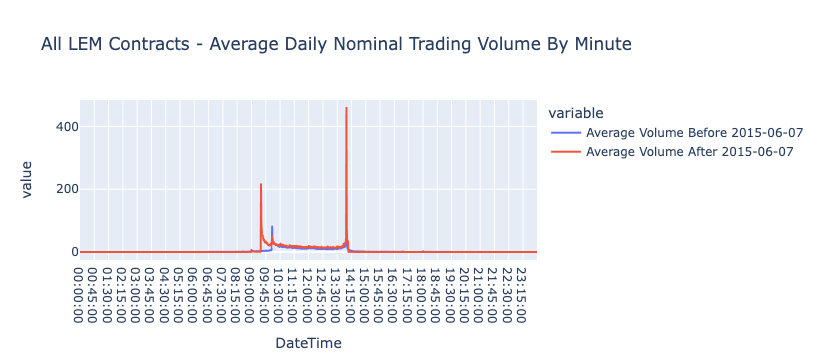

In [20]:
fig1.show()